In [9]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.pretty_print import pretty_cpt

a,b,c=[gum.LabelizedVariable(s,s,2) for s in "abc"]

# potential algebra

In [10]:
p1=gum.Potential().add(a).add(b).fillWith([1,2,3,4]).normalize()
print(pretty_cpt(p1))

   |---------------|
---|       a       |
 b |   0      1    |
---|---------------|
 0 | 0.1000 0.2000 |
 1 | 0.3000 0.4000 |
---|---------------|


In [11]:
p2=gum.Potential().add(b).add(c).fillWith([4,5,2,3]).normalize()
print(pretty_cpt(p2))

   |---------------|
---|       b       |
 c |   0      1    |
---|---------------|
 0 | 0.2857 0.3571 |
 1 | 0.1429 0.2143 |
---|---------------|


In [12]:
print(pretty_cpt(p1+p2))

       |---------------|
-------|       b       |
 c | a |   0      1    |
-------|---------------|
 0 | 0 | 0.3857 0.6571 |
 1 | 0 | 0.2429 0.5143 |
 0 | 1 | 0.4857 0.7571 |
 1 | 1 | 0.3429 0.6143 |
-------|---------------|


In [13]:
p3=p1+p2
print(pretty_cpt(p3/p3.margSumOut([p3.variable(0).name()])))

       |---------------|
-------|       c       |
 a | b |   0      1    |
-------|---------------|
 0 | 0 | 0.3699 0.3208 |
 1 | 0 | 0.3908 0.3582 |
 0 | 1 | 0.6301 0.6792 |
 1 | 1 | 0.6092 0.6418 |
-------|---------------|


# bayes formula

In [14]:
bn=gum.BayesNet()
a,b,c=[bn.add(s,3) for s in "abc"]

bn.addArc(a,c)
bn.addArc(b,c)

bn.generateCPTs()

gnb.showBN(bn)

In such a small bayes net, we can directly manipulate $P(a,b,c)$. For instance : $$P(b|c)=\frac{\sum_{a} P(a,b,c)}{\sum_{a,b} P(a,b,c)}$$

In [23]:
pABC=bn.cpt(a)*bn.cpt(b)*bn.cpt(c)
pBgivenC=(pABC.margSumOut(["a"])/pABC.margSumOut(["a","b"])).putFirst("b")

print(pretty_cpt(pBgivenC))

   |----------------------|
---|          b           |
 c |   0      1      2    |
---|----------------------|
 0 | 0.7544 0.1872 0.0584 |
 1 | 0.7881 0.1835 0.0284 |
 2 | 0.4996 0.4017 0.0987 |
---|----------------------|


# entropy of potential

In [6]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import numpy as np

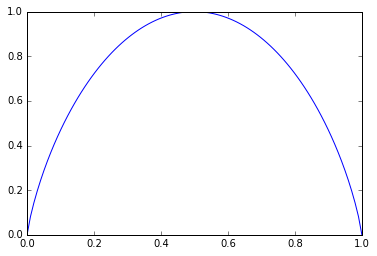

In [7]:
p1=gum.Potential().add(a)
x = np.linspace(0, 1, 100)
plt.plot(x,[p1.fillWith([p,1-p]).entropy() for p in x])
plt.show()

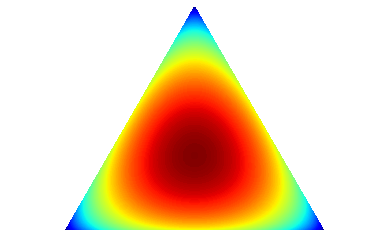

In [36]:
t=gum.LabelizedVariable('t','t',3)
p1=gum.Potential().add(t)

def entrop(bc):
    """
    bc is a list [a,b,c] close to a distribution 
    (normalized just to be sure)
    """
    return p1.fillWith(bc).normalize().entropy()

import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    """
    From 2D Cartesian coordinates to barycentric.
    """
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
    
def draw_entropy(nlevels=200, subdiv=6, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [entrop(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_entropy()